# Quantum Machine Learning

Eigenvalue problem

In [2]:
import os
import qiskit

from qiskit import *

from qiskit_aer import Aer
from qiskit_aer import *

from qiskit.visualization import *

# SciPy minimizer routine
from scipy.optimize import minimize
import time
import numpy as np

from qiskit.quantum_info import SparsePauliOp


In [3]:
with open(os.path.expanduser('~')+"/Documents/keys/ibm-token.txt") as f:
    # Newline character must be excluded
    IBM_token = f.readline()[:-1]

# Step 1. Map classical inputs to a quantum problem
$
\hat{\mathcal{H}}\ =\ 0.3980 \mathcal{Y}\mathcal{Z} - 0.3980 \mathcal{Z}\mathcal{I} - 0.0113 \mathcal{Z}\mathcal{Z} + 0.1810 \mathcal{X}\mathcal{X}$

In [4]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [5]:

from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

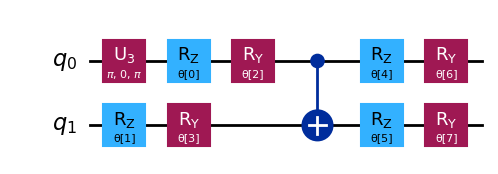

In [6]:
import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

# 2. Callback methods for better post processing

We can introcude methods that will be executed at each iteration in QuantumComputer

In [7]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


In [8]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [9]:
num_params = ansatz.num_parameters
print(num_params)
x0 = 2 * np.pi * np.random.random(num_params)

8


# 3. To Run Real Quantum Computer

In [10]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

In [11]:
# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', instance='ibm-q/open/main', token=IBM_token)

In [12]:

backend=service.least_busy(operational=True, simulator=False)
print(backend.name)
session = Session(backend=backend)
estimator = Estimator(session=session)
sampler = Sampler(session=session)

ibm_kyoto


## 3b. Obtimize Circut for Efficiency
First we need to optimize the circut to make it efficient for quantum computer

In [13]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(
            target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
        ),
    ]
)

ansatz_ibm = pm.run(ansatz)

/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


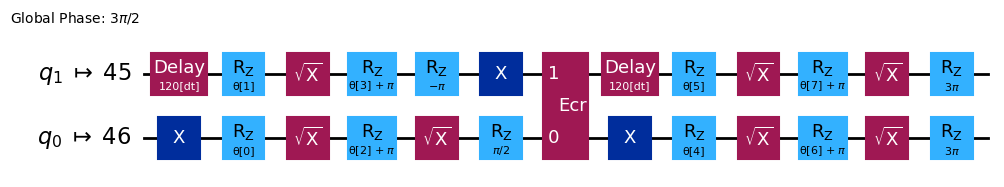

In [14]:
ansatz_ibm.draw(output="mpl", idle_wires=False, style="iqp")

In [15]:
hamiltonian_ibm = hamiltonian.apply_layout(ansatz_ibm.layout)
hamiltonian_ibm

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[ 0.398 +0.j, -0.398 +0.j, -0.0113+0.j,  0.181 +0.j])

In [21]:
options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 1024

with Session(backend=backend):
    estimator = Estimator(options=options)
    callback = build_callback(ansatz_ibm, hamiltonian_ibm, estimator, callback_dict)
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_ibm, hamiltonian_ibm, estimator),
        method="cobyla",
        callback=callback,
    )

/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)


Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/scipy/optimize/_cobyla_py.py", line 258, in calcfc
    f = fun(np.copy(x), *args)
  File "/var/folders/lx/_zyyxd0945x3lbrz0g5vm9940000gn/T/ipykernel_10662/1479460672.py", line 17, in cost_func
  File "/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/estimator.py", line 143, in run
    return super().run(
  File "/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/primitives/base/base_estimator.py", line 175, in run
    return self._run(
  File "/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/estimator.py", line 179, in _run
    return self._run_primitive(
  File "/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/base_pr

: 

qiskit_ibm_runtime.exceptions.IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)

In [16]:
jobid= "cqs4vgp88ev00080zbsg"
sessionid="cqs3ksf9nfw0008hp8h0"

retrieved_job = backend.service.job(jobid)
retrieved_job.result()


EstimatorResult(values=array([-0.4796894]), metadata=[{'variance': 0.2579336494682758, 'shots': 1024, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192, 'warning': 'Optimization level clipped from 3 to 1'}])

# 4. Post Processing

In [18]:
all(callback_dict["prev_vector"] == res.x)
callback_dict["iters"] == res.nfev

NameError: name 'res' is not defined

In [19]:
import matplotlib.pyplot as plt

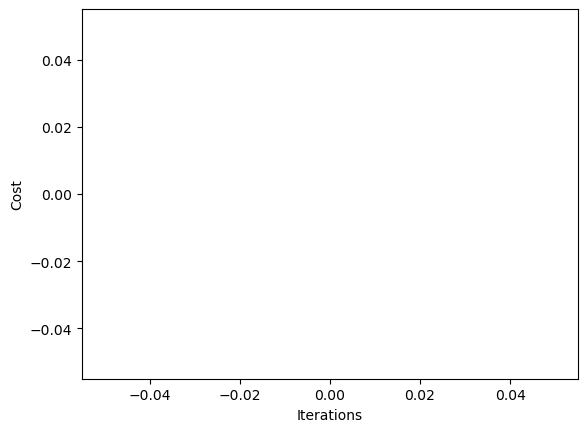

In [20]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()